<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Musterlösung / Sample solution 
## 6th exercise: <font color="#C70039">Domain Adaption with Autoencoders</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   29.06.2022

---------------------------------

### Description 
This is one implementation example to demo the image reconstruction using autoencoders for domain adaption. 
PLease do not miss to try different optimizers and losses.

---------------------------------

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import os
from   tqdm import tqdm
import time

In [2]:
SIZE=256

# import input img
input_img_data=[]
input_path = './data/heisenberg_heisenberg/gernot/'
files=os.listdir(input_path)
# read all images in the folder (different rotations and flips of the original)
for i in tqdm(files):
    img=cv2.imread(input_path+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    input_img_data.append(img_to_array(img))
# -----------------------------------------  
# import output_img
output_img_data=[]
output_path = './data/heisenberg_heisenberg/walter/'
files=os.listdir(output_path)
# read all images in the folder (same rotations and flips as img)
for i in tqdm(files):
    img=cv2.imread(output_path+'/'+i,1)  #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    output_img_data.append(img_to_array(img))

input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
input_img_array = input_img_array.astype('float32') / 255. # normalize
output_img_array= np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
output_img_array = output_img_array.astype('float32') / 255. # normalize

# Original image for prediction of output_img 
# this one does not belong to the training set
test_img_data=[]

test_img=cv2.imread('./data/heisenberg_heisenberg/gernot-heisenberg-original.jpg', 1)   #Change 0 to 1 for color images
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)#Changing BGR to RGB to show images in true colors
test_img=cv2.resize(test_img,(SIZE, SIZE))
test_img_data.append(img_to_array(test_img))

test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
test_img_array = test_img_array.astype('float32') / 255. # normalize

# set the start time
# later needed for calculating the computation time
start=time.time()

100%|██████████| 50/50 [00:00<00:00, 564.78it/s]


## Build the autoencoder-decoder model

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
     
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

#callbacks = [tf.keras.callbacks.TensorBoard(log_dir='einstein_logs')]

# fit the model of input_img to output_img 
epochs = 50
model.fit(input_img_array, output_img_array, epochs=epochs, shuffle=True)#, callbacks=callbacks)

# print out the computation time
finish=time.time()
print('total computation time = ', finish-start)

# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


ValueError: in user code:

    File "c:\Users\Lukas\Documents\Studium\Master\AML\AML\.venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Lukas\Documents\Studium\Master\AML\AML\.venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Lukas\Documents\Studium\Master\AML\AML\.venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Lukas\Documents\Studium\Master\AML\AML\.venv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Lukas\Documents\Studium\Master\AML\AML\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Lukas\Documents\Studium\Master\AML\AML\.venv\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_8" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 256, 256, 3)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
      • training=True
      • mask=None


output of test image
1/1 [==============================] - 0s 43ms/step


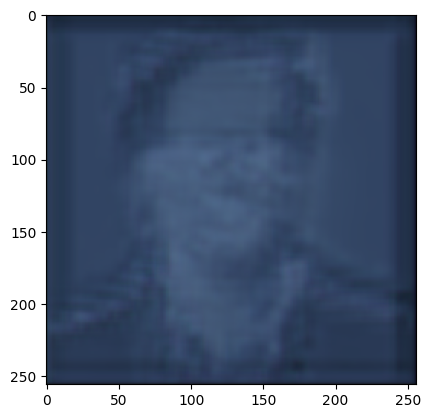

In [5]:
# predict the original image as test image, 
# since it did not belong to the training data.
# if the domain was really adapted, then the result would look like output_img

print("output of test image")
pred = model.predict(test_img_array)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.show()

In [ ]:
# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

INFO:tensorflow:Assets written to: domain_adapt_autoenc_epochs.50.model\assets
